# Earthquake Data Analysis

### Description

The catalog includes the magnitude, time of occurrence (s), and 3D coordinates (m) of earthquakes in about 20 years of recording in South California. Coordinates were converted from latitude, longitude, and depth of events in a seismic catalog. Magnitudes should be within the range $[0,8]$.

* **Waiting time (t)**: time interval between an event and the next one in the sequence.
* **Distance (r)**: Eucledian 3D distance between events. (each 3D set of coordinates refers to the hypocenter, i.e. the point triggering the slip in a fault that forms the earthquake)


### Assignments

1. Deduce what is the variable in each column of the catalog.
2. Visualize the process in space and/or time with suitable time series and/or 3D visualizations of the hypocenters. For instance, plot a space variable (a single coordinate or a nice linear combination of coordinates) as a function of time.
3. Compute the distribution $P_m(t)$ of waiting times for events of magnitude m or above (i.e. do not consider events below $m$). In shaping the bin sizes, take into account that this distribution is expected to have a power-law decay with time (e.g $\sim 1/t$), and that a power-law is well visualized in log-log scale. Do this analysis for many values of $m$, say $m=2,3,4,5$.
4. Compute the distribution $P_m(r)$ of the distance between an event and the next one, considering earthquakes of magnitude m or above. Also here make a clever choice for the bin sizes and try several values of $m$.
5. Compute the distribution $P_{m,R}(t)$ of waiting times for events of magnitude $m$ or above, which are separated by at most a distance $r<R$, for different values of m and $R$. (In this statistics, if the following event is farther than $R$, skip the $t$ and go to the next pair)
6. Eventually note if, from the analysis of the previous points, there emerges a scaling picture. Is there a suitable rescaling that collapses distributions for various $m$ (and eventually $R$ if point 5 is considered) on a single curve?

### Datasets

* column 1: index of the event
* column 2: index of the previous event that triggered it (defined with a given algorithm), -1 if no ancestor is found
* column 3: time (seconds) from 0:00 of Jan.1st, 1982
* column 4: magnitude
* columns 5, 6, and 7: 3D coordinates (meters) of the earthquake hypocenter, i.e. of the point from where it started. These Euclidean coordinates are derived from latitude, longitude and depth.

Joining each event to that with the index of the second column (if not -1), there emerges a set of causal trees.


### Contact
* Marco Baiesi <marco.baiesi@unipd.it>

In [3]:
from pandas import DataFrame
import pandas as pd
import numpy as np 
import math 
from bokeh.plotting import figure, output_file, show
from bokeh.tile_providers import CARTODBPOSITRON, get_provider
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

In [4]:
# creazione dataframe

filename = "SouthCalifornia-1982-2011_Physics-of-Data.dat"
labels = ("pointer","t","mag","x","y","z")

d=pd.read_csv(filename,sep="\s",names=labels,engine='python')
df = pd.DataFrame(data=d)
df

,pointer,t,mag,lat,long,dep
0,-1,0.000000e+00,2.71,-2571956,-4627162,3520602
1,0,3.650139e+04,2.12,-2363740,-4787011,3461373
2,0,3.748828e+04,2.33,-2363746,-4786942,3461232
3,0,4.798252e+04,2.57,-2475085,-4664024,3548479
4,0,6.026857e+04,2.98,-2238642,-4839098,3469546
...,...,...,...,...,...,...
110266,-1,9.304996e+08,2.60,-2668492,-4335735,3810743
110267,-1,9.305115e+08,2.02,-2297480,-4823870,3445285
110268,-1,9.305318e+08,2.00,-2404797,-4441247,3868121
110269,-1,9.305363e+08,2.17,-2388375,-4691191,3550903


In [5]:
#le due pdf usate per modellizzare P(r), con r appartenente a [1,600]
#600 km e'una soglia imposta a priori, ed e' dovuta al fatto che il dataset e' ristretto
#a una zona limitata, e quindi r non puo' assumere valori arbitrariamente grandi. Per valori > 650 km infatti
#la distribuzione cala rapidamente, come si vedra' negli histo con log log scale

def fit_pdf1 (r,p0):
    return p0/r

#gli abs() sono per porre p0 > 0, altrimenti non regge la defizione di pdf
def fit_pdf2 (r,p0):
    p1 = 1./(math.log( (600+abs(p0))/abs(p0)) ) 
    return p1/(r+abs(p0))


########## funzione per ottenere e analizzare gli istogrammi di P(r) #########
def r_distr (df,m,num_bins,km_range):
# df = dataframe 
# m = soglia di magnitudo
# num_bins = numero bin histo
# km_range = il range degli histo e' [0,km_range]

    #dataframe filtrato per certi valori della magnitudo
    dr = df[df["mag"]>m]
    
    #uso le colonne del dataframe per avere le distanze con cui fare l'istogramma
    distance = []
    X = np.array(dr["x"].tolist())
    Y = np.array(dr["y"].tolist())
    Z = np.array(dr["z"].tolist())
    size = len(dr["lat"])
    
    #distanza calcolata in km
    for i in range(0,size-1):
        d = np.sqrt( (X[i]-X[i+1])**2. + (Y[i]-Y[i+1])**2. + (Z[i]-Z[i+1])**2. )
        distance.append(d/1000)   

######## creazione degli histo relativi, uno con scale normali e l'altro con doppia log scale ########
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    bins_coord = ax1.hist(distance,bins=num_bins,range=(0,km_range),density=True,label="Data distribution")
    title = "r distribution for magnitude above " + str(m)
    ax1.grid()
    ax1.set_title(title)
    ax1.set_ylabel("P(r)")
    ax1.set_xlabel("r (km)")
    
    bins = np.logspace(0,3,num_bins)
    ax2.hist(distance,bins=bins,range=(0,km_range),density=True,label="Data distribution")
    title = "log log r distribution for magnitude above " + str(m)
    ax2.grid()
    ax2.set_title(title)
    ax2.set_ylabel("P(r)")
    ax2.set_xlabel("r (km)")
    ax2.set_yscale('log') 
    ax2.set_xscale('log')
    
########### fit dell'histo con le scale normali ##########
    y_bins = bins_coord[0]
    #si centrano i bins e si leva bin in eccesso
    x_bins = bins_coord[1]+km_range/(2*num_bins)
    x_bins = np.delete(x_bins,num_bins)
    
    #si considerano solo bin all'interno del "range del fit", che e' [0,600] km
    index = []
    for i in range(num_bins):
        if(x_bins[i]>600):
            index.append(i)       
    x = np.delete(x_bins,index)
    y = np.delete(y_bins,index)
   
    #fit del First model
    xspace1 = np.linspace(5, 600, 100000)
    xspace2 = np.linspace(1, 600, 100000)
    
    par1, pcov1 = curve_fit(fit_pdf1, xdata=x, ydata=y, p0=[0.15])
    ax1.plot(xspace1, fit_pdf1(xspace1, *par1), 'black', linewidth=2., label = "First model")
    ax2.plot(xspace2, fit_pdf1(xspace2, *par1), 'black', linewidth=2., label = "First model")
    
    p0 = par1[0]
    print("First model:   P(r) = %0.3f/r"% (p0))
    
    #fit del second model
    par2, pcov2 = curve_fit(fit_pdf2, xdata=x, ydata=y, p0=[0.2])
    ax1.plot(xspace1, fit_pdf2(xspace1, *par2), 'darkorange', linewidth=2., label = "Second model")
    ax2.plot(xspace2, fit_pdf2(xspace2, *par2), 'darkorange', linewidth=2., label = "Second model") 
    
    p0 = abs(par2[0])
    p1 = 1./(np.log( (600+p0)/p0)) 
    print("Second model:   P(r) = %0.3f/(r + %0.03f)" % (p1, p0))

    ax1.legend()
    ax2.legend()
    return 

First model:   P(r) = 0.147/r
Second model:   P(r) = 0.164/(r + 1.369)


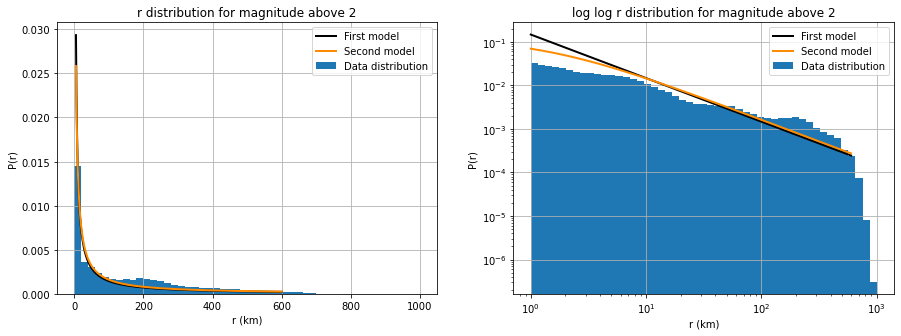

In [6]:
r_distr(df,2,50,1000)
#la coda degli istogrammi cala repentinamente a causa del fatto che il dataset e' ristretto
#a una zona limitata, e quindi r non puo' assumere valori arbitrariamente grandi.

First model:   P(r) = 0.157/r
Second model:   P(r) = 0.168/(r + 1.568)


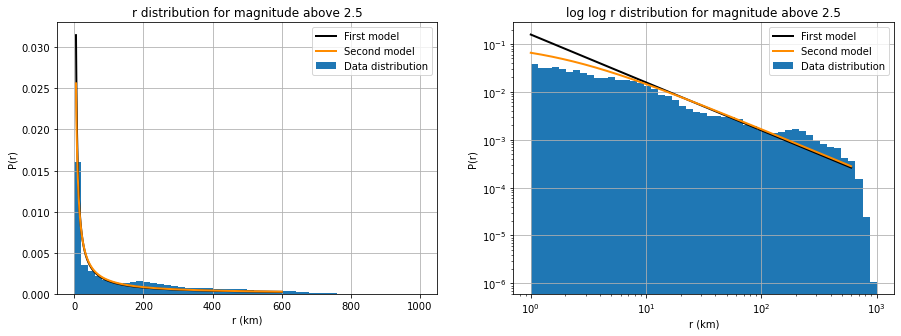

In [7]:
r_distr(df,2.5,50,1000)

First model:   P(r) = 0.169/r
Second model:   P(r) = 0.170/(r + 1.680)


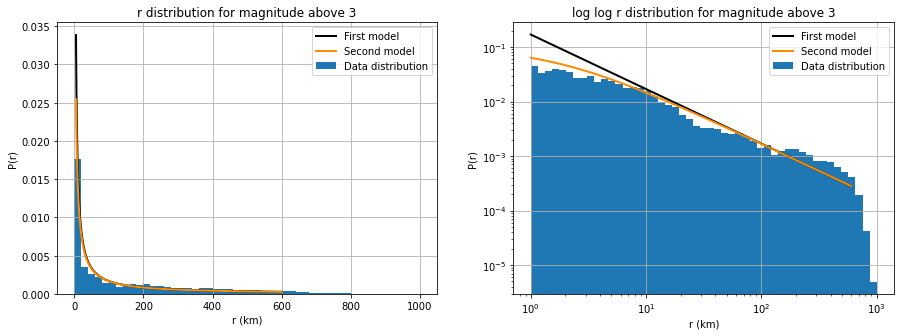

In [8]:
r_distr(df,3,50,1000)

First model:   P(r) = 0.171/r
Second model:   P(r) = 0.171/(r + 1.764)


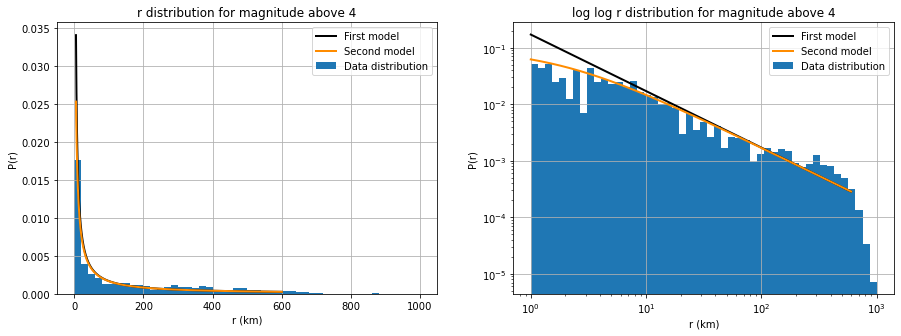

In [9]:
r_distr(df,4,50,1000)

First model:   P(r) = 0.154/r
Second model:   P(r) = 0.183/(r + 2.556)


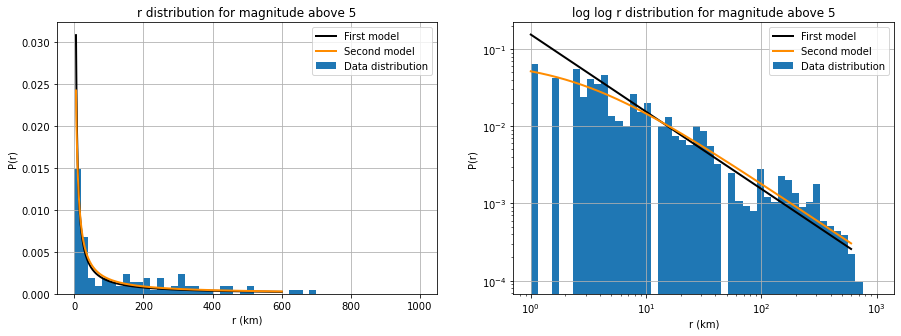

In [10]:
r_distr(df,5,50,1000)